In [8]:
import argparse
from spherenet import OmniMNIST, OmniFashionMNIST
from spherenet import SphereConv2D, SphereMaxPool2D
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

class SphereNet(nn.Module):
    def __init__(self):
        super(SphereNet, self).__init__()
        self.conv1 = SphereConv2D(1, 32, stride=1)
        self.pool1 = SphereMaxPool2D(stride=2)
        self.conv2 = SphereConv2D(32, 64, stride=1)
        self.pool2 = SphereMaxPool2D(stride=2)
        self.fc = nn.Linear(14400, 10)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = x.view(-1, 14400)  # flatten, [B, C, H, W) -> (B, C*H*W)
        x = self.fc(x)
        return x

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        if data.dim() == 3:
            data = data.unsqueeze(1)  # (B, H, W) -> (B, C, H, W)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if data.dim() == 3:
                data = data.unsqueeze(1)  # (B, H, W) -> (B, C, H, W)
            return data.shape
            output = model(data)
            test_loss += F.cross_entropy(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
test(args, sphere_model, device, test_loader)

torch.Size([128, 1, 60, 60])

In [2]:
import sys; sys.argv=['']; del sys

# Training settings
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--data', type=str, default='MNIST',
                    help='dataset for training, options={"FashionMNIST", "MNIST"}')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing')
parser.add_argument('--epochs', type=int, default=3, metavar='N',
                    help='number of epochs to train')
parser.add_argument('--optimizer', type=str, default='adam',
                    help='optimizer, options={"adam, sgd"}')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-interval', type=int, default=1, metavar='N',
                    help='how many epochs to wait before saving model weights')
args = parser.parse_args()

In [3]:
args

Namespace(batch_size=128, data='MNIST', epochs=3, log_interval=1, lr=0.1, momentum=0.9, no_cuda=False, optimizer='adam', save_interval=1, seed=1, test_batch_size=128)

In [4]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device('cuda' if use_cuda else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
np.random.seed(args.seed)

In [5]:
if args.data == 'FashionMNIST':
    train_dataset = OmniFashionMNIST(fov=120, flip=True, h_rotate=True, v_rotate=True, img_std=255, train=True)
    test_dataset  = OmniFashionMNIST(fov=120, flip=True, h_rotate=True, v_rotate=True, img_std=255, train=False, fix_aug=True)
elif args.data == 'MNIST':
    train_dataset = OmniMNIST(fov=120, flip=True, h_rotate=True, v_rotate=True, train=True)
    test_dataset  = OmniMNIST(fov=120, flip=True, h_rotate=True, v_rotate=True, train=False, fix_aug=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size     , shuffle=True , **kwargs)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=args.test_batch_size, shuffle=False, **kwargs)

In [6]:
# Train
sphere_model = SphereNet().to(device)
#model = Net().to(device)
if args.optimizer == 'adam':
    sphere_optimizer = torch.optim.Adam(sphere_model.parameters(), lr=args.lr)
elif args.optimizer == 'sgd':
    sphere_optimizer = torch.optim.SGD(sphere_model.parameters(), lr=args.lr, momentum=args.momentum)

In [7]:
for epoch in range(1, args.epochs + 1):
    # SphereCNN
    print('{} Sphere CNN {}'.format('='*10, '='*10))
    #train(args, sphere_model, device, train_loader, sphere_optimizer, epoch)
    test(args, sphere_model, device, test_loader)
    if epoch % args.save_interval == 0:
        torch.save(sphere_model.state_dict(), 'sphere_model.pkl')

========== Sphere CNN ==========


C:\Users\ustundag\Desktop\SphereNet_pytorch\spherenet\sphere_cnn.py:49: RuntimeWarning: divide by zero encountered in true_divide
  new_theta = theta + arctan(x*sin(v) / (rho*cos(phi)*cos(v) - y*sin(phi)*sin(v)))



Test set: Average loss: 0.1487, Accuracy: 1036/10000 (10%)

========== Sphere CNN ==========


KeyboardInterrupt: 

In [40]:
for i_batch in enumerate(test_loader):
    print(type(i_batch))
    break

<class 'tuple'>


label:  tensor(0)


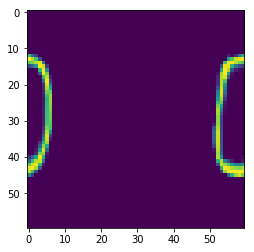

In [37]:
import  matplotlib.pyplot as plt
k = 10
print('label: ', lists[1][k])
plt.imshow(lists[0][k])
plt.show()